# Quality Assesment Notebook for DLAs in Mocks

To-do for this notebook:
    - look at evolution of 1d stack with redshift and NHI
    - look at the values of beta and bias DLA
    - look at their evolution with redshift and with NHI
    - compute the 3d auto-correlations of DLAs
    - compute the 3d cross-correlation DLA x QSO

Conclusion:
    - create the catalog and apply the survey
    - distribution NHI very different. Is it only an efficiency issue?
    - mean NHI different
    - distribution of NHI vs. redshift very different
    - Why is the distribution of Lambda_RF not flat at low lRF?
    - bias of DLA is too low
    - Are there RSD in zDLA?
    - look at mocks where quickquasar was run with DLA, i.e. the Damping wing effect
    - To get the randoms: 
        select some (ra,dec,z) at random that represent the host quasar and then
        for each of these set multiple random DLAs, as you do for mocked data DLA.
        The consequence is that we will have multiple random DLAs for each random line of sight.
        It would be nice also to have a ID for each random line of sight and another for each random DLA.
    - Should we care about a possible correlation between NHI and bias_DLA.
        In  ́Perez-Rafols et al 2017 (https://arxiv.org/pdf/1709.00889.pdf) it is compatible with zero

In [10]:
import fitsio
import scipy as sp
import scipy.constants
from scipy.interpolate import interp1d
import glob
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import h5py
import os
import subprocess
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
import astropy.io.fits as pyfits

import picca.constants
from picca import wedgize

%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
plt.rc('text',usetex=True)

Path to the mocks catalogs and outputs

In [11]:
nside = 16

In [12]:
### Get mocks
mock = {}
mock['mock_ver'] = 'v3.2'
mock['quick_ver'] = 'quick-0.2'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/saclay/'+mock['mock_ver']+'/'
mock['mock_quick'] = mock['mock_base']+'/'+mock['quick_ver']+'/'

In [13]:
### Get mock products
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/saclay/'+mock['mock_ver']+'/'+mock['quick_ver']+'/'
#mock['picca_Correlations'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/'+mock['mock_ver']+'/Correlations/'
#mock['picca_xcf1d_DLA'] = mock['picca_Correlations']+'/xcf1d_DLA.fits.gz'
#mock['picca_xcf_DLA'] = mock['picca_Correlations']+'/xcf_DLA.fits.gz'
#mock['picca_xcf_DLA_fit'] = mock['picca_Correlations']+'/Fit/LYA_DLA__noMetals/result.h5'

Path to quickquasar mock catalogs and outputs

In [14]:
mockQuick = {}
mockQuick['mock_ver'] = 'v4.0.0'
mockQuick['quick_ver'] = 'quick-0.0.1'
mockQuick['save_path'] = '/project/projectdirs/desi/users/alxogm/mocks/london/'+mockQuick['mock_ver']+'/'+mockQuick['quick_ver']+'/Correlations/'
mockQuick['mock_base'] = '/project/projectdirs/desi/mocks/lya_forest/london/'+mockQuick['mock_ver']+'/'
mockQuick['Catalogs'] = mockQuick['mock_base']+mockQuick['quick_ver']+'/'
mockQuick['QSO_catalog'] = mockQuick['mock_base']+'/master.fits'
mockQuick['DLA_catalog'] = mockQuick['Catalogs']+'DLA.fits.gz'

Path to the data catalogs and outputs

In [15]:
data = {}
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
data['Catalogs'] = '/global/homes/h/hdumasde/Data/Catalogs/'
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v3_1.fits'
data['DLA_catalog'] = data['Catalogs']+'/dr14dlasv2/dr14dlasv2.fits'
data['picca_xcf1d_DLA'] = '$HOME/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/Correlations_LYA/xcf1d_forest1_LYA_obj1_DLA.fits.gz'
data['picca_xcf_DLA'] = '$HOME/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/Correlations_LYA/forFits_xcf_forest1_LYA_line1_LYA_obj1_DLA.fits.gz'
data['picca_xcf_DLA_fit'] = '$HOME/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/Correlations_LYA/Fit/LYA_DLA__noMetals/result.h5'

In [20]:
fs = glob.glob(mock['mock_base']+'/*/*/transmission-16-*.fits')
fs = sp.sort(sp.array(fs))[:1]

f_radla = sp.array([],dtype=float)
f_decdla = sp.array([],dtype=float)
f_zdla = sp.array([],dtype=float)
f_mockiddla = sp.array([],dtype=sp.int64)
f_zqsodla = sp.array([],dtype=float)
f_nhidla = sp.array([],dtype=float)

for j,f in enumerate(fs):
    h = fitsio.FITS(f)

    ra = h['METADATA']['RA'][:]
    dec = h['METADATA']['DEC'][:]
    zqso = h['METADATA']['Z'][:]
    mockid = h['METADATA']['MOCKID'][:]

    mockiddla = h['DLA']['MOCKID'][:]
    w = sp.in1d(mockid,mockiddla)
    ra = ra[w]
    dec = dec[w]
    zqso = zqso[w]
    mockid = mockid[w]
    frommockidtora = {mockid[i]:ra[i] for i in range(ra.size)}
    frommockidtodec = {mockid[i]:dec[i] for i in range(ra.size)}
    frommockidtozqso = {mockid[i]:zqso[i] for i in range(ra.size)}
    radla = [ frommockidtora[i] for i in mockiddla ]
    decdla = [ frommockidtodec[i] for i in mockiddla ]
    zqsodla = [ frommockidtozqso[i] for i in mockiddla ]

    f_radla = sp.append(f_radla,radla)
    f_decdla = sp.append(f_decdla,decdla)
    f_zqsodla = sp.append(f_zqsodla,zqsodla)
    f_mockiddla = sp.append(f_mockiddla,mockiddla)
    f_zdla = sp.append(f_zdla,h['DLA']['Z_DLA'][:])
    f_nhidla = sp.append(f_nhidla,h['DLA']['N_HI_DLA'][:])

    h.close()

### Sort
w = sp.argsort(f_mockiddla)
for el in [f_radla,f_decdla,f_mockiddla,f_zdla,f_mockiddla,f_mockiddla,f_mockiddla,f_nhidla,f_zqsodla]:
    el = el[w]

### Save
out = fitsio.FITS(mock['picca']+'/Catalogs/DLA.fits','rw',clobber=True)
cols = [f_radla,f_decdla,f_mockiddla,f_zdla,f_mockiddla,f_mockiddla,f_mockiddla,f_nhidla,f_zqsodla]
names = ['RA','DEC','THING_ID','Z','PLATE','MJD','FIBERID','NHI','ZQSO']
out.write(cols,names=names)
out.close()

OSError: extension not found: 4 (case insensitive)

# __Compare catalog to data__

## Redshift distribution

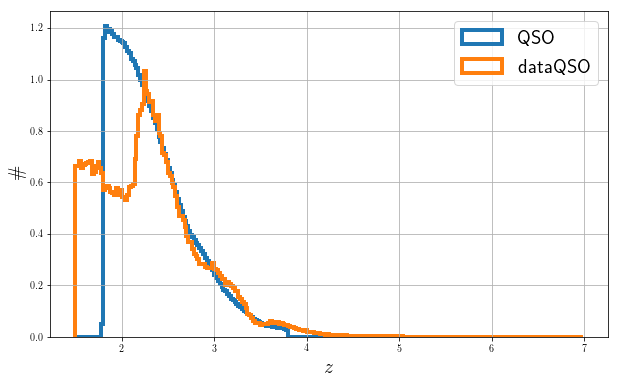

In [237]:
toPlot = {'QSO':mock['mock_base']+'master.fits',
         'dataQSO':data['QSO_catalog']}
redshift_key = {'QSO':'Z_QSO_RSD','dataQSO':'Z'}

bins = sp.arange(1.5,7.,0.02)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

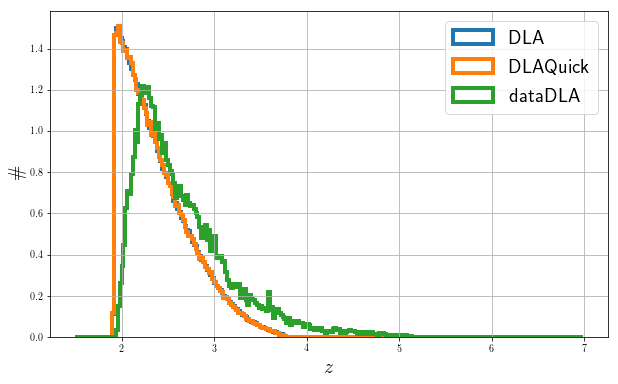

In [172]:
toPlot = {'DLA':mock['DLA_catalog'],
          #'DLArandom':mock['DLA_random_catalog'],
         'DLAQuick':mockQuick['DLA_catalog'],
         'dataDLA':data['DLA_catalog']}
redshift_key = {'DLA':'Z_DLA_RSD', 'DLArandom':'Z', 'DLAQuick':'ZDLA','dataDLA':'Z'}

bins = sp.arange(1.5,7.,0.02)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

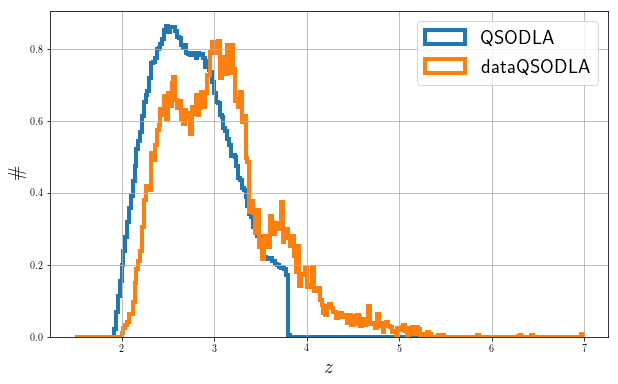

In [173]:
toPlot = {'QSODLA':mock['DLA_catalog'],
         'dataQSODLA':data['DLA_catalog']}
redshift_key = {'QSODLA':'Z_QSO_RSD', 'dataQSODLA':'ZQSO'}

bins = sp.arange(1.5,7.,0.02)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

## Redshift ratio

In [174]:
def getHisto(data,bins,weights=None):
    if weights is None:
        weights = sp.ones(data.size)
    hist, axisX = sp.histogram(data,bins=bins, weights=weights)
    xxx = sp.array([ axisX[i]+(axisX[i+1]-axisX[i])/2. for i in range(axisX.size-1) ])

    return xxx,hist

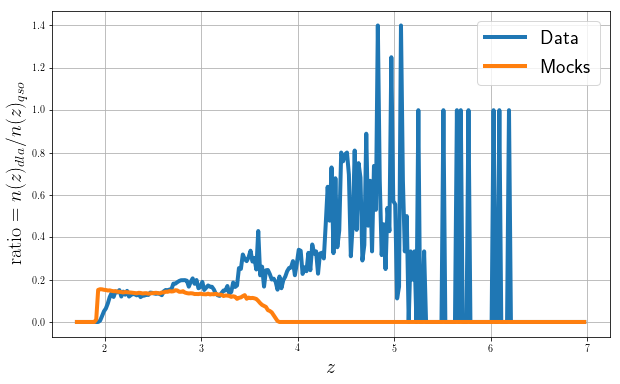

In [175]:
toPlot = {'QSO':mock['QSO_catalog'],
         'DLA':mock['DLA_catalog'],
         'dataQSO':data['QSO_catalog'],
         'dataDLA':data['DLA_catalog']}
redshift_key = {'QSO':'Z_QSO_RSD', 'DLA':'Z_DLA_RSD', 'dataQSO':'Z','dataDLA':'Z'}

bins = sp.arange(1.7,7.,0.02)
for tpe in ['data','']:
    h = fitsio.FITS(toPlot[tpe+'QSO'])
    zqso = h[1][redshift_key[tpe+'QSO']][:]
    h.close()
    h = fitsio.FITS(toPlot[tpe+'DLA'])
    zdla = h[1][redshift_key[tpe+'DLA']][:]
    h.close()
    xqso, yqso = getHisto(zqso,bins)
    xdla, ydla = getHisto(zdla,bins)
    w = yqso>0.
    ydla[w] /= 1.*yqso[w]
    if tpe=='':
        label = 'Mocks'
    else:
        label = 'Data'
    plt.plot(xdla,ydla,label=label)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{ratio} = n(z)_{dla}/n(z)_{qso}$')
plt.legend()
plt.grid()

## Redshift ratio for the host quasar

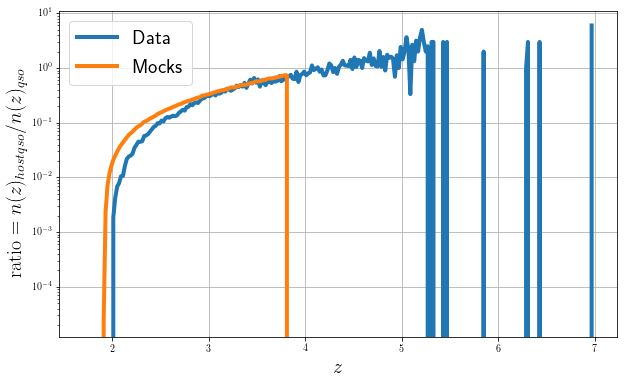

In [176]:
toPlot = {'QSO':mock['QSO_catalog'],
         'DLA':mock['DLA_catalog'],
         'dataQSO':data['QSO_catalog'],
         'dataDLA':data['DLA_catalog']}
redshift_key = {'QSO':'Z_QSO_RSD', 'DLA':'Z_QSO_RSD', 'dataQSO':'Z','dataDLA':'ZQSO'}

bins = sp.arange(1.7,7.,0.02)
for tpe in ['data','']:
    h = fitsio.FITS(toPlot[tpe+'QSO'])
    zqso = h[1][redshift_key[tpe+'QSO']][:]
    h.close()
    h = fitsio.FITS(toPlot[tpe+'DLA'])
    zdla = h[1][redshift_key[tpe+'DLA']][:]
    h.close()
    xqso, yqso = getHisto(zqso,bins)
    xdla, ydla = getHisto(zdla,bins)
    w = yqso>0.
    ydla[w] /= 1.*yqso[w]
    if tpe=='':
        label = 'Mocks'
    else:
        label = 'Data'
    plt.plot(xdla,ydla,label=label)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{ratio} = n(z)_{host qso}/n(z)_{qso}$')
plt.yscale('log')
plt.legend()
plt.grid()

## NHI distribution

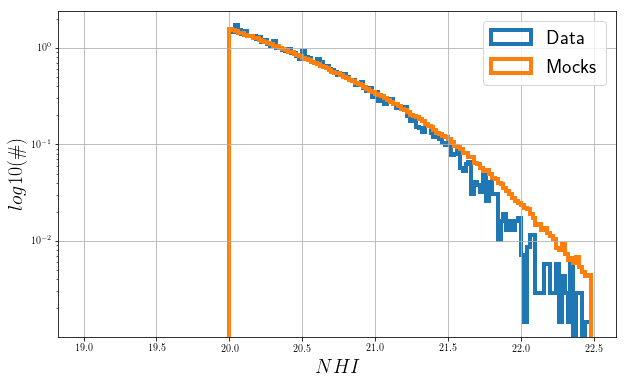

In [178]:
toPlot = {'Mocks':mock['DLA_catalog'],
          'Data':data['DLA_catalog']}
NHI_key = {'Mocks':'N_HI_DLA', 'Data':'NHI'}
bins = sp.arange(19.,22.5,0.02)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    nhi = h[1][NHI_key[name]][:]
    h.close()
    plt.hist(nhi,bins=bins,histtype='step',label=name,density=True,linewidth=4)

plt.yscale('log')
plt.xlabel(r'$NHI$')
plt.ylabel(r'$log10(\mathrm{\#})$')
plt.legend()
plt.grid()

Define a function to compute de distribution function of DLAs and compare with Noterdaeme et.al.2012 and to pygm expected distribution. 

In [179]:
def fNH(zqso,nhi,zmin=0,bins=15):
    Xmin = cosmo.absorption_distance(zmin)
    dX = cosmo.absorption_distance(zqso)-Xmin
    n,bins = sp.histogram(nhi,bins=bins)
    deltanhi = 10**bins-10**(sp.roll(bins,1))
    bins = bins[1:]
    fNHI = sp.log10(n/(deltanhi[1:]*dX.sum()))
    return bins, fNHI

##READ DISTRIBUTIONS TO COMPARE WITH. NOTE THAT THE NOTERDAEME 2012 DISTRIBUTON AS WELL AS PYIGM IS CORRECTED,
##AND THEREFORE THERE IS A SMALL DIFFERENCE WITH RESPECT TO THE ONE WE FIND IN DR14. TO DO: ADD ALSO THE N2012 WITHOUT CORRECTION
ND = Table.read('/project/projectdirs/desi/mocks/lya_forest/london/tools/expectedfNHI.fits',hdu=2)
pygm = Table.read('/project/projectdirs/desi/mocks/lya_forest/london/tools/expectedfNHI.fits',hdu=1)

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/numpy/lib/scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


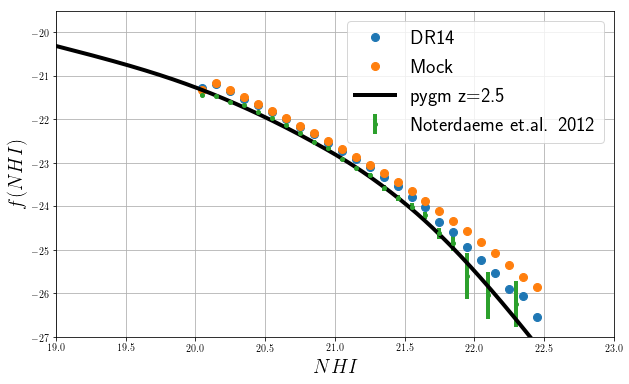

In [180]:
toPlot = {'DR14':data['DLA_catalog'],
          'Mock':mock['DLA_catalog'],
          #'quickMock':mockQuick['DLA_catalog']
         }
NHI_key = {'Mock':'N_HI_DLA', 'DR14':'NHI'}
redshift_key = { 'Mock':'Z_DLA_RSD','quickMock':'ZDLA','DR14':'Z'}
redshift_qso_key = { 'Mock':'Z_QSO_RSD','quickMock':'ZQSO','DR14':'ZQSO'}

bins = sp.arange(19.25,22.5,0.1)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    nhi = h[1][NHI_key[name]][:]
    zqso = h[1][redshift_qso_key[name]][:]    
    zdla = h[1][redshift_key[name]][:]
    w = (zdla<=3.6) & (zdla>2)
    nhi = nhi[w]
    zqso = zqso[w]
    zdla = zdla[w]
    nhi,fnhi = fNH(zqso,nhi,zmin=0,bins=bins)
    plt.plot(nhi,fnhi,'o',label=name,markersize=8)

plt.plot(pygm['logNHI'],pygm['logfz2.5'],linewidth=4,color='black',label='pygm z=2.5')
plt.errorbar(ND['logNHI'],ND['logf'],yerr=ND['sigma_logf'],fmt='o',markersize=4,label='Noterdaeme et.al. 2012')

plt.xlabel(r'$NHI$')
plt.ylabel(r'$f(NHI)$')
plt.xlim(19,23)
plt.ylim(-27,-19.5)
plt.legend()
plt.grid()


## z_qso - z_dla distribution

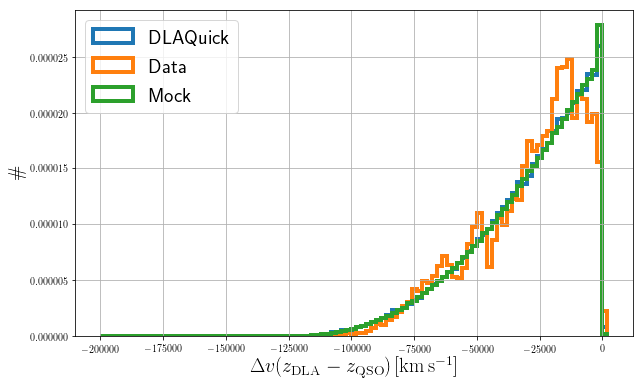

In [181]:
toPlot = {'Mock':mock['DLA_catalog'],'DLAQuick':mockQuick['DLA_catalog'],'Data':data['DLA_catalog']}
redshift_key = { 'Data':'Z', 'Mock':'Z_DLA_RSD','DLAQuick':'ZDLA'}
redshift_qso_key = { 'Mock':'Z_QSO_RSD','quickMock':'ZQSO','Data':'ZQSO','DLAQuick':'ZQSO'}

bins = sp.arange(-200000.,4000.,2000.)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    zdla = h[1][redshift_key[name]][:]
    zqso = h[1][redshift_qso_key[name]][:]
    c = (scipy.constants.speed_of_light/1000.) #- km/s
    dv = c*(zdla-zqso)/(1.+zqso)
    h.close()
    plt.hist(dv,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$\Delta v(z_{\mathrm{DLA}}-z_{\mathrm{QSO}}) \, [\mathrm{km\,s^{-1}}]$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend(loc=2)
plt.grid()

## lambda_RF distribution

We need to compute for that the distribution of pixels as a function of lambda_RF

In [182]:
lObs_min = 3600.
lObs_max = 7235.
lRF_min = 400.
lRF_max = 1500.
toPlot = {'Mocks':{'DLA':mock['DLA_catalog'], 'PIXELS':None},
          'Data':{'DLA':data['DLA_catalog'], 'PIXELS':None}}

In [183]:
### For the mocks
fs = glob.glob(mock['mock_base']+'/*/*/transmission-16-*.fits')
fs = sp.sort(sp.array(fs))[:10]

lRF_stack = sp.arange(lRF_min,lRF_max,10.)
n_lRF_stack = sp.zeros(lRF_stack.size)
nbForests = 0

for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    h.close()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = (lRF>lRF_min) & (lRF<lRF_max) & (lObs>lObs_min) & (lObs<lObs_max)
    lRF = lRF[w]
    nbForests += z.size
    
    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    n_lRF_stack += sp.bincount(bins,minlength=lRF_stack.size)

h = fitsio.FITS(mock['mock_base']+'/master.fits')
nbForestsTot = h[1]['Z_QSO_RSD'][:].size
n_lRF_stack *= 1.*nbForestsTot/nbForests

toPlot['Mocks']['PIXELS'] = [lRF_stack,n_lRF_stack]

In [184]:
### For the data

h = fitsio.FITS(data['QSO_catalog'])
nbForestsTot = ( (h[1]['Z'][:]>1.8) & (h[1]['PLATE'][:]>=3520) ).sum()
w = (h[1]['Z'][:]>1.8) & (sp.arange(h[1]['Z'][:].size)<1000) & (h[1]['PLATE'][:]>=3520)
z = h[1]['Z'][:][w]
plate = h[1]['PLATE'][:][w]
mjd = h[1]['MJD'][:][w]
fiberid = h[1]['FIBERID'][:][w]
pm = plate*1000000000 + mjd*10000
nbForestsTot = plate.size
h.close()


lRF_stack = sp.arange(lRF_min,lRF_max,10.)
n_lRF_stack = sp.zeros(lRF_stack.size)
nbForests = 0

for tpm in sp.unique(pm):
    m = (tpm // 10000) % 100000
    p = (tpm // (10000 * 100000))
    path = data['Spectra']+str(p).zfill(4)+'/spPlate-' +str(p).zfill(4)+'-'+str(m)+'.fits'
    h = fitsio.FITS(path)
    ivar = h[1].read()
    end = h[2].read()
    hdr = h[0].read_header()
    h.close()

    wave = hdr['CRVAL1'] + hdr['CD1_1']*sp.arange(hdr['NAXIS1'])
    if hdr['DC-FLAG']:
        wave = 10**wave

    w = pm==tpm
    tf = fiberid[w]
    tz = z[w]
    for ttf, ttz in zip(tf,tz):
        waveRF = wave/(1.+ttz)
        w = (ivar[ttf-1,:]>0.) & (end[ttf-1,:]==0) & (wave>lObs_min) & (wave<lObs_max) & (waveRF>lRF_min) & (waveRF<lRF_max)
    waveRF = waveRF[w]
    nbForests += 1.

    bins = ( ( waveRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    n_lRF_stack += sp.bincount(bins,minlength=lRF_stack.size)

n_lRF_stack *= 1.*nbForestsTot/nbForests
toPlot['Data']['PIXELS'] = [lRF_stack,n_lRF_stack]

Let's compare the distribution

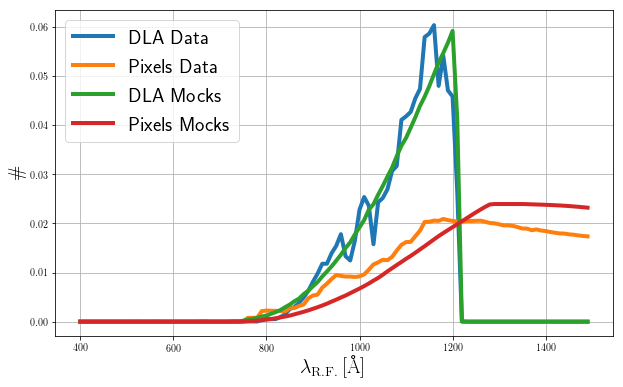

In [185]:
redshift_key = { 'Data':'Z', 'Mocks':'Z_DLA_RSD'}
redshift_qso_key = { 'Mocks':'Z_QSO_RSD','Data':'ZQSO'}
for name in sorted(toPlot):
    h = fitsio.FITS(toPlot[name]['DLA'])
    zdla = h[1][redshift_key[name]][:]
    zqso = h[1][redshift_qso_key[name]][:]
    lRF = (1.+zdla)*1215.67/(1.+zqso)
    h.close()
    
    [lRF_stack,n_lRF_stack_PIXELS] = toPlot[name]['PIXELS']
    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    n_lRF_stack_DLA = sp.bincount(bins,minlength=lRF_stack.size)
    plt.plot(lRF_stack,n_lRF_stack_DLA/n_lRF_stack_DLA.sum(),linewidth=4,label='DLA '+name)
    plt.plot(lRF_stack,n_lRF_stack_PIXELS/n_lRF_stack_PIXELS.sum(),linewidth=4,label='Pixels '+name)
    
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

Let' compare the ratio to the two distribution

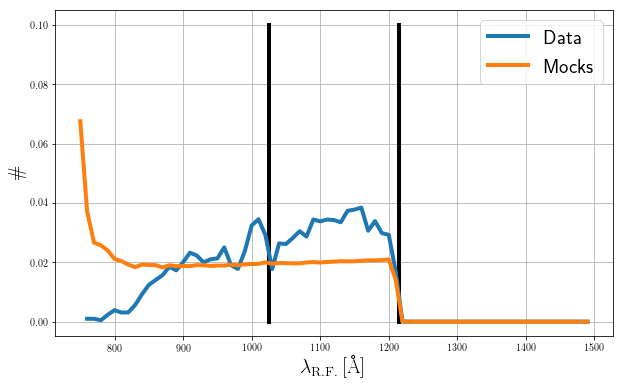

In [186]:
absorber_IGM = {'LYA': 1215.67,'LYB' : 1025.72}
for k,v in absorber_IGM.items():
    plt.plot([v,v],[0.,0.1],color='black')
    
for name in sorted(toPlot):
    h = fitsio.FITS(toPlot[name]['DLA'])
    zdla = h[1][redshift_key[name]][:]
    zqso = h[1][redshift_qso_key[name]][:]
    lRF = (1.+zdla)*1215.67/(1.+zqso)
    h.close()

    [lRF_stack,n_lRF_stack_PIXELS] = toPlot[name]['PIXELS']
    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    n_lRF_stack_DLA = sp.bincount(bins,minlength=lRF_stack.size)

    w = n_lRF_stack_PIXELS>0.
    xxx = lRF_stack[w]
    yyy = n_lRF_stack_DLA[w]/n_lRF_stack_PIXELS[w]
    plt.plot(xxx,yyy/yyy.sum(),linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

The following function allows to get the profile

In [187]:
def Get_TProfile(ar1, ar2, nbBin1, we2=None):

    if we2 is None:
        we2 = sp.ones_like(ar1)
    number, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1))
    weight, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2)
    mean,   axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*ar2)
    err,    axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*(ar2**2.))

    ### find the axis X
    axisX = sp.array([ axisX[i]+(axisX[i+1]-axisX[i])/2. for i in range(0,axisX.size-1) ])
    
    ### Get only not empty bins
    bool_number = (number[:,0]>1)
    
    axisX  = axisX[bool_number]
    number = number[:,0][bool_number]
    weight = weight[:,0][bool_number]
    mean   = mean[:,0][bool_number]
    err    = err[:,0][bool_number]

    mean  = mean/weight
    err   = sp.sqrt((err/weight-mean**2.)/number)

    return axisX, mean, err, number

The following function allows to have a 2d histogram

In [188]:
def Get_2DTProfile(ar1, ar2, ar3, nbBinsX, nbBinsY,we=None):

    if we is None:
        we = sp.ones_like(ar1)
    d = sp.array(list(zip(ar1,ar2,ar3)))
    number, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1))
    weight, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we  )
    mean,   axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*ar3)
    err,    axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*(ar3**2.))

    w = number>1
    mean[w]   /= weight[w]
    err[w]    = sp.sqrt((err[w]/weight[w]-mean[w]**2.)/number[w])

    mean   = mean[:,:,0]
    err    = err[:,:,0]
    number = number[:,:,0]

    return mean, err, number

## NHI vs. redshift

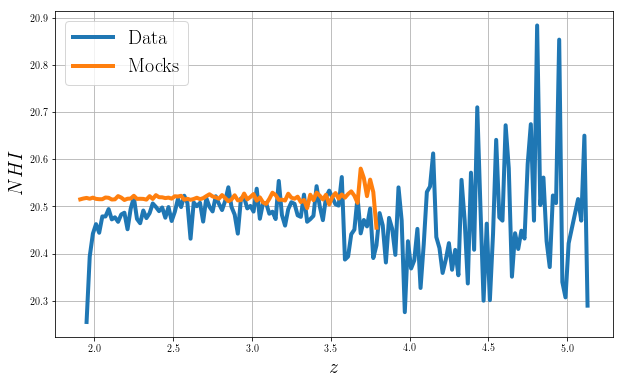

In [189]:
toPlot = {'Mocks':mock['DLA_catalog'], 'Data':data['DLA_catalog']}
NHI_key = {'Mocks':'N_HI_DLA', 'Data':'NHI'}
redshift_key = { 'Data':'Z', 'Mocks':'Z_DLA_RSD'}

bins = sp.arange(1.5,7.,0.02)
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    nhi = h[1][NHI_key[name]][:]
    z = h[1][redshift_key[name]][:]
    axisX, mean, err, number = Get_TProfile(z,nhi,bins)
    plt.plot(axisX, mean,linewidth=4,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r'$z$')
plt.ylabel(r'$NHI$')
plt.legend()
plt.grid()

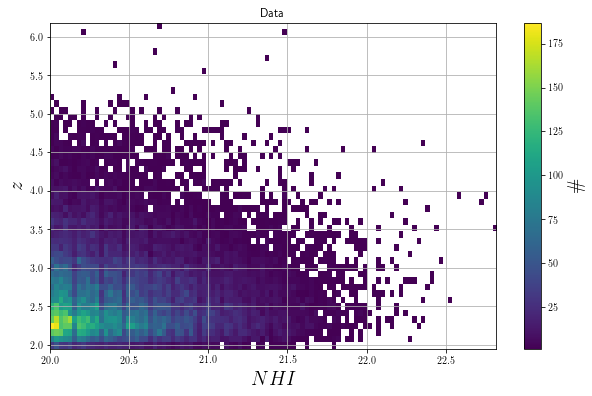

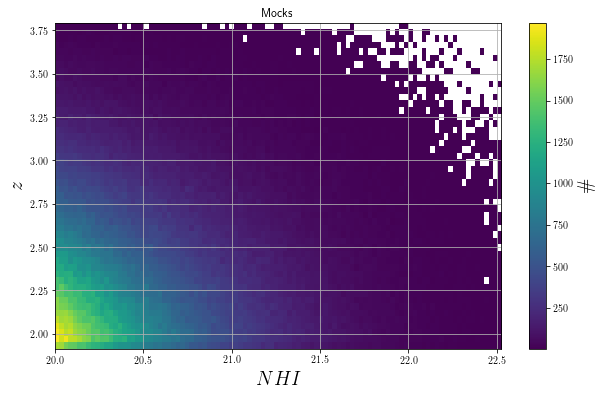

In [190]:
toPlot = {'Mocks':mock['DLA_catalog'], 'Data':data['DLA_catalog']}
for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    nhi = h[1][NHI_key[name]][:]
    z = h[1][redshift_key[name]][:]
    extent = [nhi.min(), nhi.max(), z.min(), z.max()]
    
    mean_nb, err_nb, number_nb = Get_2DTProfile(nhi, z, sp.ones(nhi.size), 100, 50)
    number_nb = sp.transpose(number_nb)
    number_nb[number_nb==0.] = sp.nan
    plot1 = plt.imshow(number_nb, interpolation='nearest', origin='lower', aspect='auto',extent=extent)
    cbar1 = plt.colorbar(plot1)
    cbar1.set_label(r'$\#$',size=20)
    cbar1.update_ticks()
    plt.title(name)
    plt.xlabel(r'$NHI$')
    plt.ylabel(r'$z$')
    plt.grid()
    plt.show()

## Distribution number of DLA per forests

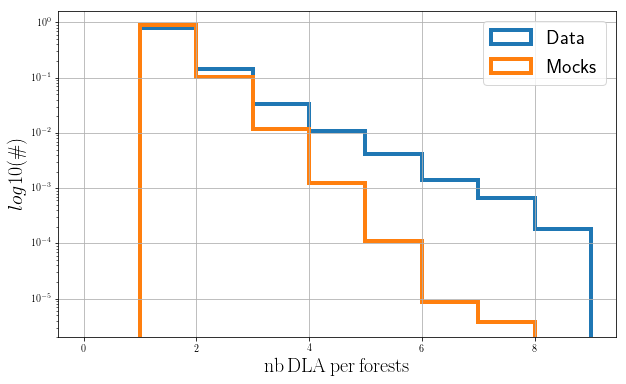

In [191]:
toPlot = {'Mocks':mock['DLA_catalog'], 'Data':data['DLA_catalog']}
thid_key = {'Mocks':'MOCKID', 'Data':'THING_ID'}

for name,path in sorted(toPlot.items()):
    h = fitsio.FITS(path)
    thid = h[1][thid_key[name]][:]
    thidunique = sp.unique(thid)
    nbRepeat = sp.bincount(thid)
    nbRepeat = nbRepeat[thidunique]
    plt.hist(nbRepeat, bins=sp.arange(nbRepeat.max()+1),histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$\mathrm{nb\,DLA\,per\,forests}$')
plt.ylabel(r'$log10(\#)$')
plt.yscale('log')
plt.legend()
plt.grid()

## Distribution on the sky

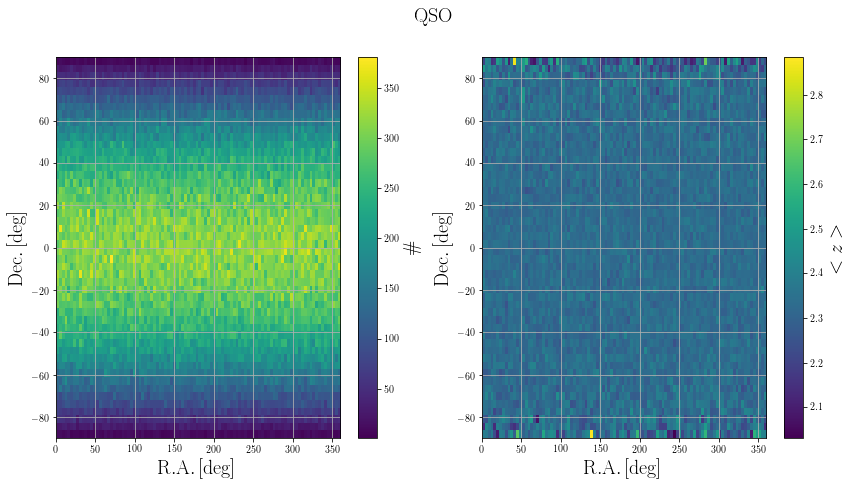

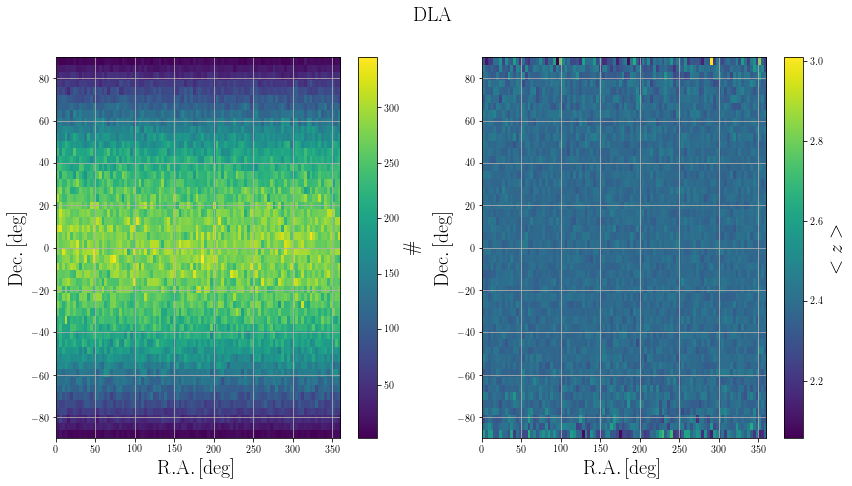

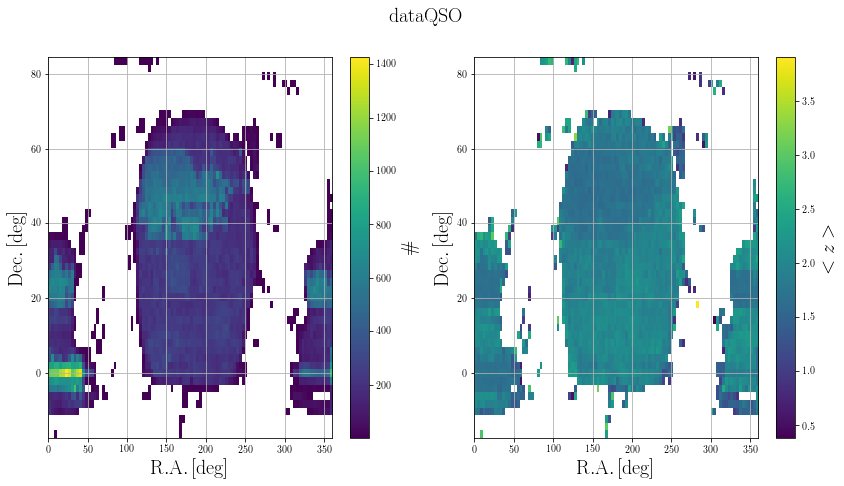

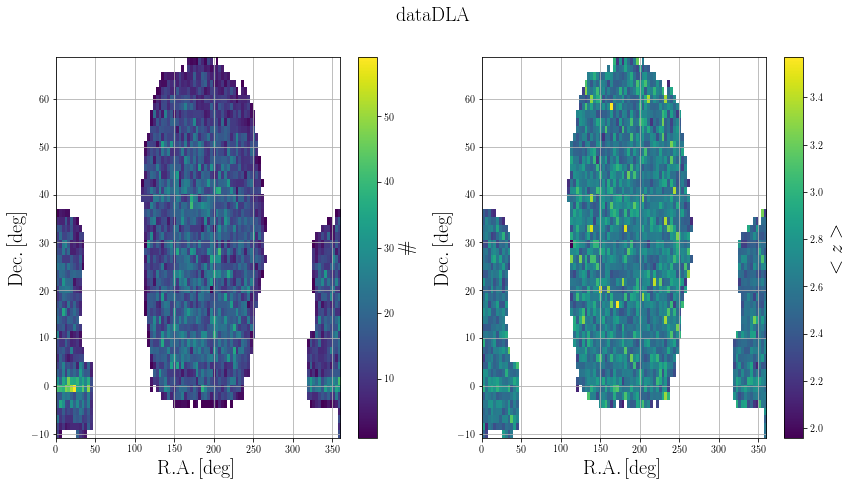

In [192]:
sp.random.seed(42)
nbQSO = 1000000
toPlot = {'QSO':mock['QSO_catalog'],
         'DLA':mock['DLA_catalog'],
        #'DLArandom':mock['DLA_random_catalog'],
         'dataQSO':data['QSO_catalog'],
         'dataDLA':data['DLA_catalog']}
redshift_key = {'QSO':'Z_QSO_RSD', 'DLA':'Z_DLA_RSD', 'DLArandom':'Z', 'dataQSO':'Z','dataDLA':'Z'}

for name,path in toPlot.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]
    h.close()
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    
    mean_nb, err_nb, number_nb = Get_2DTProfile(ra, dec, sp.ones(ra.size), 100, 50)
    number_nb = sp.transpose(number_nb)
    number_nb[number_nb==0.] = sp.nan
    plot1 = ax1.imshow(number_nb, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar1 = plt.colorbar(plot1, ax=ax1)
    cbar1.set_label(r'$\#$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()
    
    mean_z, err_z, number_z = Get_2DTProfile(ra, dec, z, 100, 50)
    mean_z = sp.transpose(mean_z)
    number_z = sp.transpose(number_z)
    mean_z[number_z==0.] = sp.nan
    plot2 = ax2.imshow(mean_z, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar2 = plt.colorbar(plot2,ax=ax2)
    cbar2.set_label(r'$<z>$',size=20)
    cbar2.update_ticks()
    ax2.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax2.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax2.grid()
    
    plt.subplots_adjust(wspace=0.2)

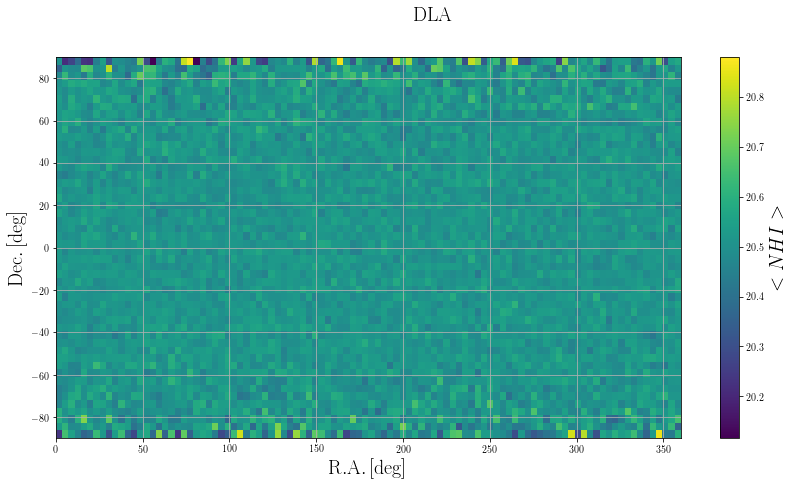

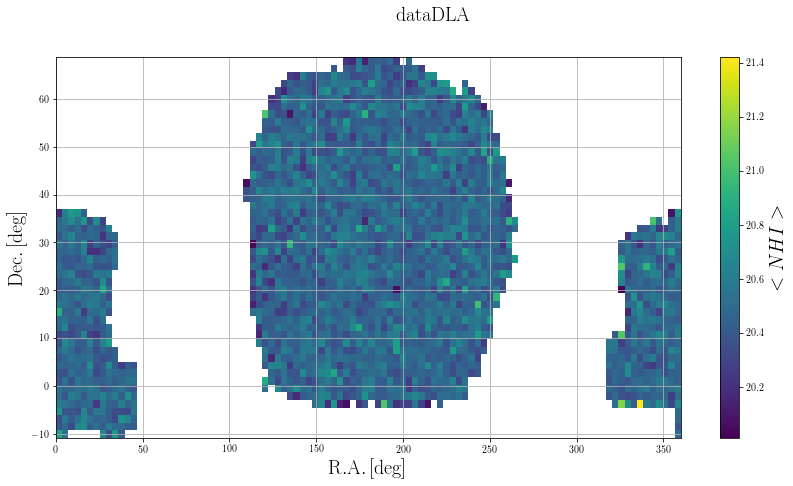

In [193]:
sp.random.seed(42)
nbQSO = 100000000
toPlot = {'DLA':mock['DLA_catalog'],
         'dataDLA':data['DLA_catalog']}
NHI_key = {'DLA':'N_HI_DLA', 'dataDLA':'NHI'}

for name,path in toPlot.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    nhi = h[1][NHI_key[name]][:]
    h.close()
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    nhi = nhi[w]
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]

    f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
    
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    mean_nhi, err_nhi, number_nhi = Get_2DTProfile(ra, dec, nhi, 100, 50)
    mean_nhi = sp.transpose(mean_nhi)
    number_nhi = sp.transpose(number_nhi)
    mean_nhi[number_nhi==0.] = sp.nan
    plot1 = ax1.imshow(mean_nhi, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar1 = plt.colorbar(plot1,ax=ax1)
    cbar1.set_label(r'$<NHI>$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()

# __Lya Transmission__

In [209]:
### Get all transmission files
fs = sp.sort(glob.glob(mock['mock_base']+'/*/*/transmission-*-*.fits'))
fs = fs[:100]
lLYA = 1215.67
lminforest = 1215.67

In [210]:
### Along the observed wavelength 
lObs_min = 3000.
lObs_max = 8000.

lObs_stack = sp.arange(lObs_min,lObs_max,1.)
z_stack = lObs_stack/lLYA-1.
T_stack = sp.zeros(lObs_stack.size)
TVar_stack = sp.zeros(lObs_stack.size)
n_stack = sp.zeros(lObs_stack.size)

In [211]:
### Get the transmission
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = lRF<lminforest
    lObs = lObs[w]
    lRF = lRF[w]
    trans = trans[w]

    bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*lObs_stack.size ).astype(int)
    T_stack += sp.bincount(bins,weights=trans,minlength=lObs_stack.size)
    TVar_stack += sp.bincount(bins,weights=trans**2,minlength=lObs_stack.size)
    n_stack += sp.bincount(bins,minlength=lObs_stack.size)

In [212]:
### Normalize the vectors (obseved wavelength)
w = n_stack>0.
T_stack[w] /= n_stack[w]
TVar_stack[w] /= n_stack[w]
TVar_stack -= T_stack**2
trans_vs_lObs = interp1d(lObs_stack[w],T_stack[w],fill_value='extrapolate',kind='nearest')

In [213]:
### Along the rest-frame wavelength
lRF_min = 100.
lRF_max = 4000.

lRF_stack = sp.arange(lRF_min,lRF_max,1.)

T_lRF_stack_delta = sp.zeros(lRF_stack.size)
TVar_lRF_stack_delta = sp.zeros(lRF_stack.size)
n_lRF_stack_delta = sp.zeros(lRF_stack.size)

T_lRF_stack_delta_DLA = sp.zeros(lRF_stack.size)
TVar_lRF_stack_delta_DLA = sp.zeros(lRF_stack.size)
n_lRF_stack_delta_DLA = sp.zeros(lRF_stack.size)

In [214]:
### Get the delta
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    mockid = h['METADATA']['MOCKID'][:]
    frommockidtoid = { idd:i for i,idd in enumerate(mockid) }

    z_DLA = h['DLA']['DZ_DLA_RSD'][:]
    mockid_DLA = h['DLA']['MOCKID'][:]
    h.close()

    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    trans = trans/trans_vs_lObs(lObs)-1.
    w = (lRF>lRF_min) & (lRF<lRF_max) & (lRF<lminforest)
    
    bins = ( ( lRF[w]-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    T_lRF_stack_delta += sp.bincount(bins,weights=trans[w],minlength=lRF_stack.size)
    TVar_lRF_stack_delta += sp.bincount(bins,weights=trans[w]**2,minlength=lRF_stack.size)
    n_lRF_stack_delta += sp.bincount(bins,minlength=lRF_stack.size)

    for i in range(z_DLA.size):
        idx = frommockidtoid[mockid_DLA[i]]
        tlRF = lRF[idx]
        ttlRF = lObs[idx]/(1.+z_DLA[i])
        ttrans = trans[idx]
        tw = (ttlRF>lRF_min) & (ttlRF<lRF_max) & (tlRF<lminforest)

        bins = ( ( ttlRF[tw]-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
        T_lRF_stack_delta_DLA += sp.bincount(bins,weights=ttrans[tw],minlength=lRF_stack.size)
        TVar_lRF_stack_delta_DLA += sp.bincount(bins,weights=ttrans[tw]**2,minlength=lRF_stack.size)
        n_lRF_stack_delta_DLA += sp.bincount(bins,minlength=lRF_stack.size)

In [215]:
### Normalize the vectors (rest-frame wavelength)
w = n_lRF_stack_delta>0.
T_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta -= T_lRF_stack_delta**2

w = n_lRF_stack_delta_DLA>0.
T_lRF_stack_delta_DLA[w] /= n_lRF_stack_delta_DLA[w]
TVar_lRF_stack_delta_DLA[w] /= n_lRF_stack_delta_DLA[w]
TVar_lRF_stack_delta_DLA -= T_lRF_stack_delta_DLA**2

Delta as a function of Rest-Frame wavelength

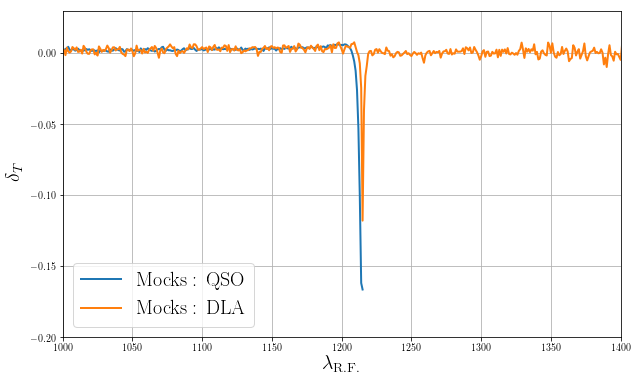

In [216]:
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],T_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,QSO}$')
w = n_lRF_stack_delta_DLA>0.
plt.plot(lRF_stack[w],T_lRF_stack_delta_DLA[w],linewidth=2,label=r'$\mathrm{Mocks:\,DLA}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$')
plt.ylabel(r'$\delta_{T}$')
plt.legend()
plt.xlim([1000.,1400.])
plt.ylim([-0.2,0.03])
plt.grid()

Variance of delta as a function of Rest-Frame wavelength

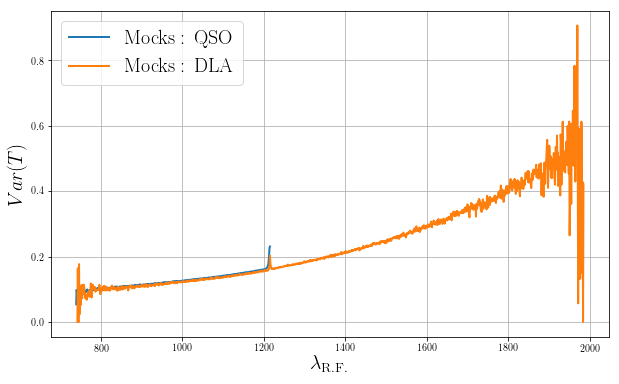

In [217]:
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],TVar_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,QSO}$')
w = n_lRF_stack_delta_DLA>0.
plt.plot(lRF_stack[w],TVar_lRF_stack_delta_DLA[w],linewidth=2,label=r'$\mathrm{Mocks:\,DLA}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$')
plt.ylabel(r'$Var(T)$')
plt.legend()
plt.grid()

# __Example spectrum__

In [218]:
### Get the different path to spectrum
trans_path = mock['mock_base']+'/0/0/transmission-16-0.fits'
spec_path = mock['mock_base']+mock['quick_ver']+'/spectra-16/0/0/spectra-16-0.fits'

In [219]:
### Get delta nside
h = fitsio.FITS(mock['delta_attributes'])
nside = h[1].read_header()['NSIDE']
h.close()

OSError: File not found: '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.2.0/quick-0.0/iter.fits.gz'

In [292]:
### Get the spectrum
h = fitsio.FITS(spec_path)
hra = h['FIBERMAP']['RA_TARGET'][:]
hde = h['FIBERMAP']['DEC_TARGET'][:]
tid = h['FIBERMAP']['TARGETID'][:]
b_ll = sp.log10(h['B_WAVELENGTH'].read())
b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
b_fl = h['B_FLUX'].read()
r_ll = sp.log10(h['R_WAVELENGTH'].read())
r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
r_fl = h['R_FLUX'].read()
z_ll = sp.log10(h['Z_WAVELENGTH'].read())
z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
z_fl = h['Z_FLUX'].read()

In [293]:
### Get Transmission
h = fitsio.FITS(trans_path)
z = h['METADATA']['Z'][:]
ra = h['METADATA']['RA'][:]
mockid = h['METADATA']['MOCKID'][:]
de = h['METADATA']['DEC'][:]
lObs = h['WAVELENGTH'].read()
trans = h['TRANSMISSION'].read()
iddla = h['DLA']['MOCKID'][:]
zdla = h['DLA']['Z_DLA'][:]

h.close()
lRF = lObs/(1.+z[:,None])
lObs = lObs*sp.ones(z.size)[:,None]

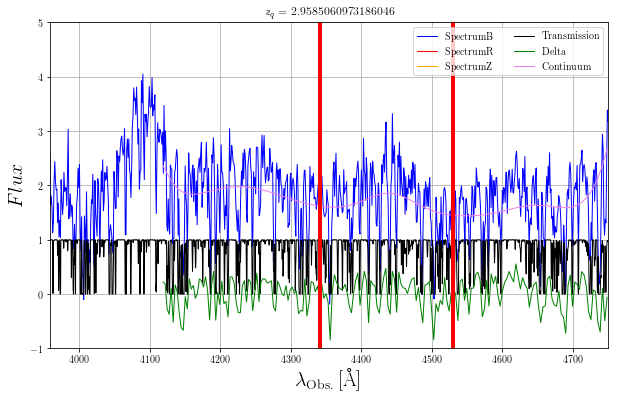

In [295]:
### Plot the first n spectra
for idx in range(100):
    ra_idx = hra[idx]
    de_idx = hde[idx]
    z_idx = z[ra==hra[idx]][0]
    tid_idx = tid[idx]

    delt_pix = healpy.ang2pix(nside, sp.pi/2.-de_idx*sp.pi/180., ra_idx*sp.pi/180.)
    delta = fitsio.FITS(mock['delta']+'/delta-'+str(delt_pix)+'.fits.gz')
    deltaa = delta[str(tid_idx)]

    nidx = sp.arange(ra.size)[ra==ra_idx][0]
    mockid_this = mockid[ra==ra_idx][0]
    if mockid_this not in iddla:
        continue

    plt.plot(10**b_ll,b_fl[idx,:],color='blue',label=r'$\mathrm{Spectrum B}$',linewidth=1)
    plt.plot(10**r_ll,r_fl[idx,:],color='red',label=r'$\mathrm{Spectrum R}$',linewidth=1)
    plt.plot(10**z_ll,z_fl[idx,:],color='orange',label=r'$\mathrm{Spectrum Z}$',linewidth=1)
    plt.plot(lObs[nidx,:],trans[nidx,:],color='black',label=r'$\mathrm{Transmission}$',linewidth=1)
    plt.plot(10**deltaa['LOGLAM'][:],deltaa['DELTA'][:],color='green',label=r'$\mathrm{Delta}$',linewidth=1)
    plt.plot(10**deltaa['LOGLAM'][:],deltaa['CONT'][:],color='violet',label=r'$\mathrm{Continuum}$',linewidth=1)
    
    for zdla_this in zdla[sp.in1d(iddla,mockid_this)]:
        lObsdla_this = (1.+zdla_this)*1215.67
        plt.plot([lObsdla_this,lObsdla_this],[-1.,10.],color='red',linewidth=4)
    
    plt.title(r'$z_{q} = '+str(z[ra==hra[idx]][0])+'$')
    plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{\AA{}}]$')
    plt.ylabel(r'$Flux$')
    plt.legend(ncol=2,fontsize=10)
    plt.grid()
    plt.xlim([1000.*(1.+z[ra==hra[idx]][0]),1200.*(1.+z[ra==hra[idx]][0])])
    plt.ylim([-1.,5.])
    break

# __Convert the catalog to DRQ format__

In [226]:
### Data
h = fitsio.FITS(mock['mock_base']+'/master_DLA.fits')
data = {}
for k in ['RA','DEC']:
    data[k] = h[1][k][:]
data['Z'] = h[1]['Z_DLA_RSD'][:]
data['THING_ID'] = h[1]['MOCKID'][:]
data['PLATE'] = h[1]['MOCKID'][:]
data['MJD'] = h[1]['MOCKID'][:]
data['FIBERID'] = h[1]['MOCKID'][:]
h.close()

### Save data
print(data['RA'].size)
print(mock['Catalogs'])
out = fitsio.FITS(mock['Catalogs']+'/DLA.fits.gz','rw',clobber=True)
cols = [ v for k,v in data.items() ]
names = [ k for k in data.keys() ]
out.write(cols,names=names)
out.close()

896749
/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.2.0/Catalog/


# __Stack along the line of sight__

Let's look at the stack of the delta along the line of sight

Simply run the following command in your terminal

In [238]:
cmd = 'do_xcf1d.py'
cmd += ' --out '+mock['picca_xcf1d_DLA']
cmd += ' --in-dir '+mock['picca_delta']
cmd += ' --drq '+mock['Catalogs']+'/DLA.fits.gz'
cmd += ' --wr-min 0.5 --wr-max 1.5 --np 5000'
print(cmd)
print()
"""
for i in sp.arange(15,24,0.5):
    if not os.path.isfile(mock['DLA_catalog'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))):
        continue
    cmd = 'do_xcf1d.py'
    cmd += ' --out '+mock['xcf1d_DLA'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))
    cmd += ' --in-dir '+mock['delta']
    cmd += ' --drq '+mock['DLA_catalog'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))
    cmd += ' --wr-min 0.5 --wr-max 1.5 --np 5000'
    print(cmd)
    print()
"""

do_xcf1d.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.2.0/Correlations//xcf1d_DLA.fits.gz --in-dir /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.2.0/quick-0.0/deltas/ --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.2.0/Catalog//DLA.fits.gz --wr-min 0.5 --wr-max 1.5 --np 5000



"\nfor i in sp.arange(15,24,0.5):\n    if not os.path.isfile(mock['DLA_catalog'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))):\n        continue\n    cmd = 'do_xcf1d.py'\n    cmd += ' --out '+mock['xcf1d_DLA'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))\n    cmd += ' --in-dir '+mock['delta']\n    cmd += ' --drq '+mock['DLA_catalog'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))\n    cmd += ' --wr-min 0.5 --wr-max 1.5 --np 5000'\n    print(cmd)\n    print()\n"

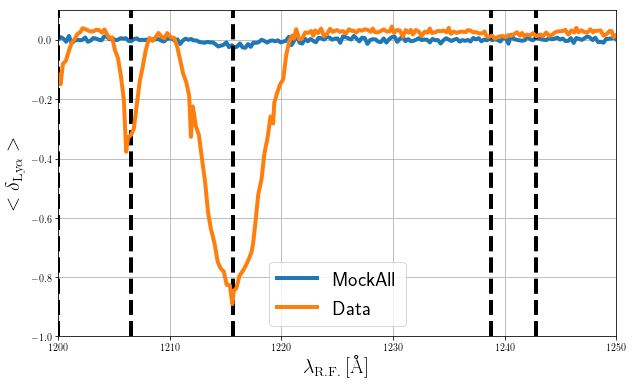

In [239]:
toPlot = {'MockAll':mock['picca_xcf1d_DLA'], 'Data':data['picca_xcf1d_DLA']}
#for i in sp.arange(15,24,0.5):
#    if not os.path.isfile(mock['xcf1d_DLA'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))):
#        continue
#    toPlot['MockNHI'+str(i)+''+str(i+0.5)] = mock['xcf1d_DLA'].replace('DLA','DLA__NHI_'+str(i)+'_'+str(i+0.5))

for name,path in sorted(toPlot.items())[::-1]:
    h = fitsio.FITS(path)
    rp = h[1]['RP'][:]
    da = h[2]['DA'][:]
    we = h[2]['WE'][:]
    da = (da*we).sum(axis=0)
    we = we.sum(axis=0)
    w = we>0
    da[w] /= we[w]
    for n,l in picca.constants.absorber_IGM.items():
        if l<(1215.67*rp[w]).min() or l>(1215.67*rp[w]).max(): continue
        plt.plot([l,l],[-1.,0.2],'--',color='black')
    plt.plot(1215.67*rp[w],da[w],linewidth=4,label=name)
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$<\delta_{\mathrm{Ly\alpha}}>$')
plt.legend()
plt.ylim([-1.,0.1])
plt.xlim([1200.,1250.])
plt.grid()
plt.show()

# __The 3D cross-correlation LYA-QSO__

Let's look at the correlation between DLA and Lya within different line-of-sights

Simply run the following command in your terminal

In [131]:
cmd = 'do_xcf.py'
cmd += ' --out '+mock['xcf_DLA']
cmd += ' --in-dir '+mock['delta']
cmd += ' --drq '+mock['DLA_catalog']
print(cmd)

do_xcf.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/xcf_DLA.fits.gz --in-dir /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/quick-0.0/deltas/ --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA.fits.gz


We also need to compute the distortion matrix

In [30]:
cmd = 'do_xdmat.py'
cmd += ' --out '+mock['xcf_DLA'].replace('xcf','xdmat')
cmd += ' --in-dir '+mock['delta']
cmd += ' --drq '+mock['DLA_catalog']
cmd += ' --rej 0.98'
print(cmd)

do_xdmat.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/xdmat_DLA.fits.gz --in-dir /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/quick-0.0/deltas/ --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA.fits.gz --rej 0.98


And to export the results

In [31]:
cmd = 'export.py'
cmd += ' --out '+mock['xcf_DLA'].replace('xcf','xcf-exp')
cmd += ' --data '+mock['xcf_DLA']
cmd += ' --dmat '+mock['xcf_DLA'].replace('xcf','xdmat')
print(cmd)

export.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/xcf-exp_DLA.fits.gz --data /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/xcf_DLA.fits.gz --dmat /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations/xdmat_DLA.fits.gz


## Wedge plots

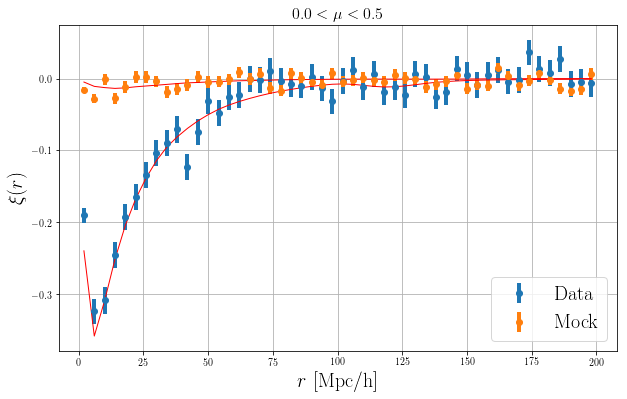

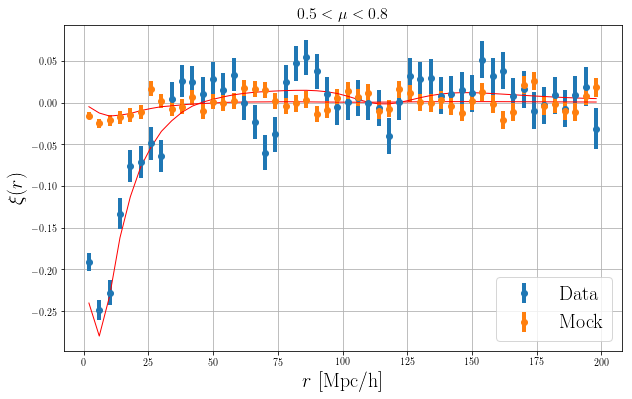

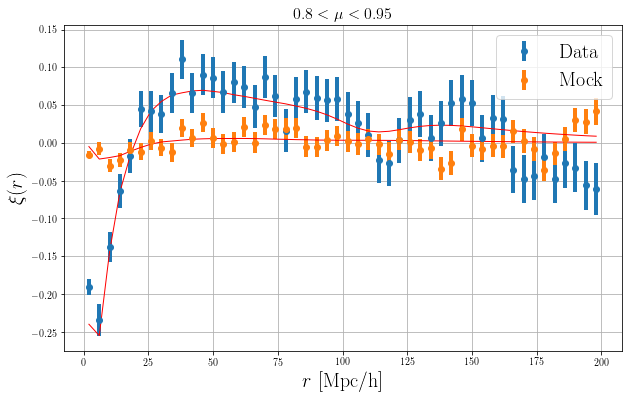

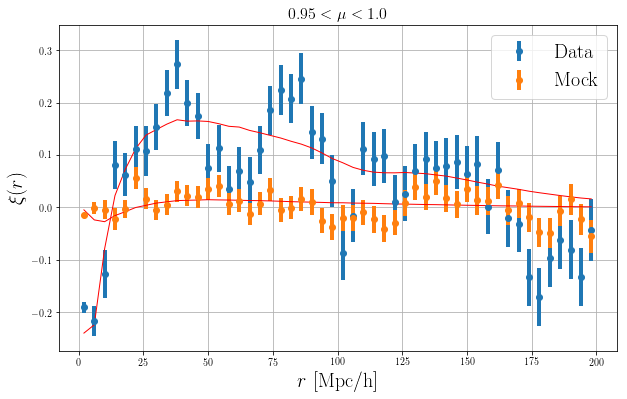

In [32]:
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['xcf_DLA'].replace('xcf','xcf-exp'), 'FIT':mock['xcf_DLA_fit'], 'NAME':'LYA(LYA)xDLA' }
toPlot['Data'] = { 'CORR':data['xcf_DLA'], 'FIT':data['xcf_DLA_fit'], 'NAME':'LYA(LYA)xDLA' }

mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r,yerr=sp.sqrt(c.diagonal())*r,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(r,f*r,color='red',linewidth=1)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## Slice plots

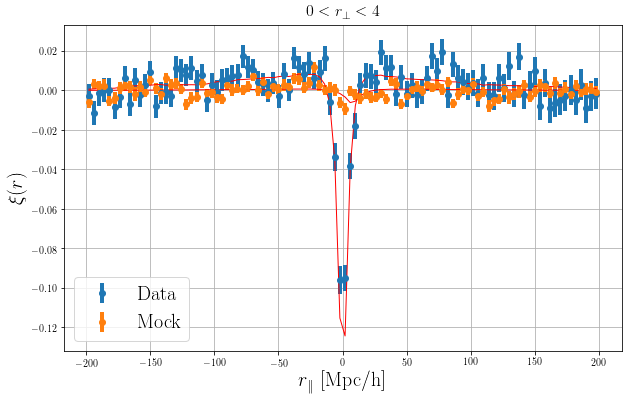

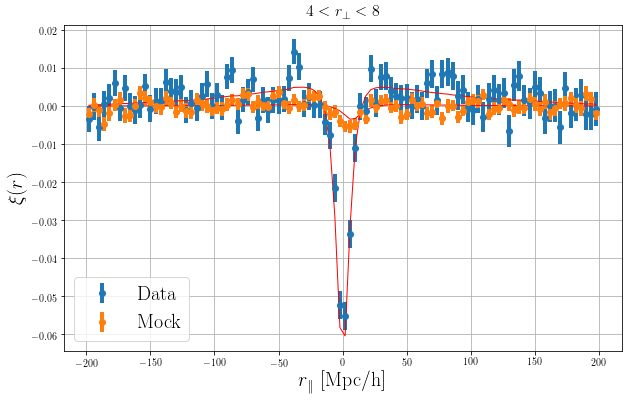

In [33]:
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['xcf_DLA'].replace('xcf','xcf-exp'), 'FIT':mock['xcf_DLA_fit'], 'NAME':'LYA(LYA)xDLA' }
toPlot['Data'] = { 'CORR':data['xcf_DLA'], 'FIT':data['xcf_DLA_fit'], 'NAME':'LYA(LYA)xDLA' }

slices = [0, 1]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=1)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## The covariance matrix

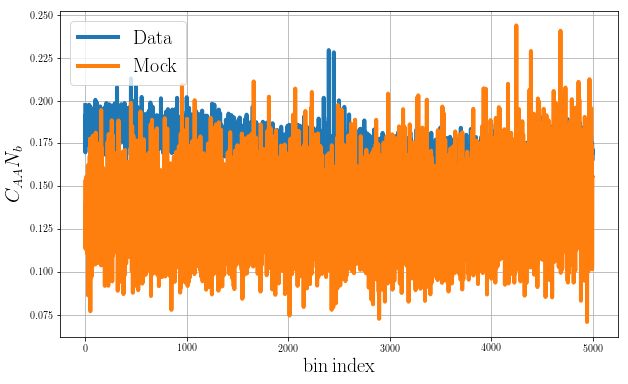

In [34]:
### The cross-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['xcf_DLA'].replace('xcf','xcf-exp') }
toPlot['Data'] = { 'CORR':data['xcf_DLA'] }

for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    co = sp.diag(h[1]['CO'][:])
    plt.plot(nb*co,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$C_{AA} N_{b}$")
plt.legend()
plt.grid()

## The correlation matrix

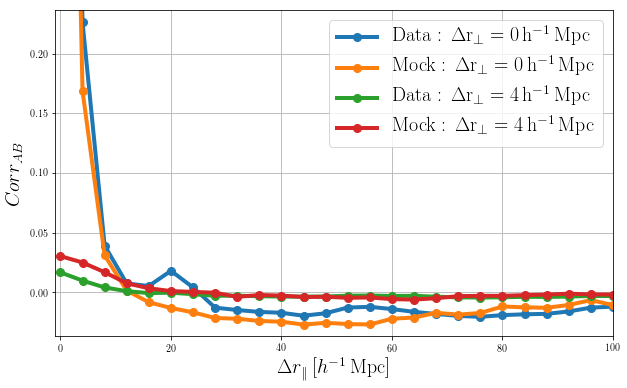

In [35]:
### The cross-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['xcf_DLA'].replace('xcf','xcf-exp') }
toPlot['Data'] = { 'CORR':data['xcf_DLA'] }

### Load
corr = {}
for name,paths in sorted(toPlot.items()):
    corr[name] = {}
    h = fitsio.FITS(paths['CORR'])
    corr[name]['CO'] = h[1]['CO'][:]
    tvar = sp.diag(corr[name]['CO'])
    corr[name]['NBBIN'] = tvar.size
    corr[name]['NT'] = h[1].read_header()['NT']
    corr[name]['BINSIZE'] = h[1].read_header()['RTMAX']/h[1].read_header()['NT']
    tcor = corr[name]['CO']/sp.sqrt(tvar*tvar[:,None])
    corr[name]['COR'] = tcor.copy()
    h.close()

### Plot
ymin = 1.
ymax = -1.
for j in range(2):
    for name,tc in sorted(corr.items()):
        c = tc['COR'].copy()
        a = sp.array( [ sp.mean(sp.diagonal(c, offset=(tc['NT']*i+j))) for i in range(tc['NBBIN']//tc['NT']) ])
        label = '\mathrm{'+name+': \, \Delta r_{\perp} = '+str(int(tc['BINSIZE']*j))+'\,h^{-1}\, \mathrm{Mpc}}'
        plt.plot(tc['BINSIZE']*sp.arange(tc['NBBIN']//tc['NT']),a,linewidth=4,marker='o',markersize=8, label=r'$'+label+'$')
        ymin = min(ymin,a.min())
        ymax = max(ymax,a[a!=1.].max())
plt.xlabel(r'$\Delta r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$')
plt.ylabel(r'$Corr_{AB}$')
plt.xlim([-1.,100.])
plt.ylim([ymin-0.01,ymax+0.01])
plt.legend()
plt.grid()
plt.show()

# Compute the 3D auto-correlation of DLAs

### Redshift interval

In [172]:
zint = ['0:10']

## Convert random catalogs to DRQ

In [195]:
nbData = 800000
nbRandoms = 2*nbData

### Data
h = fitsio.FITS(mock['DLA_catalog'])
data = {}
for k in ['RA','DEC','THING_ID','PLATE','MJD','FIBERID','Z']:
    data[k] = h[1][k][:]
h.close()
phi = data['RA']*sp.pi/180.
th = sp.pi/2.-data['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
data['PIX'] = pix

### Randoms
h = fitsio.FITS(mock['DLA_random_catalog'])
rand = {}
for k in ['RA','DEC','Z']:
    rand[k] = h[1][k][:]
for k in ['THING_ID','PLATE','MJD','FIBERID']:
    rand[k] = data['THING_ID'].max()+1+sp.arange(rand['RA'].size)
h.close()
phi = rand['RA']*sp.pi/180.
th = sp.pi/2.-rand['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
rand['PIX'] = pix

### Same HEALpix
w = sp.in1d(data['PIX'],rand['PIX'])
print((~w).sum())
for k,v in data.items():
    v = v[w]
w = sp.in1d(rand['PIX'],data['PIX'])
print((~w).sum())
for k,v in rand.items():
    v = v[w]

### Save data
print(data['RA'].size)
assert nbData<=data['RA'].size
w = sp.random.choice(sp.arange(data['RA'].size), size=nbData, replace=False)
out = fitsio.FITS(mock['Catalogs']+'/DLA_D_'+str(nbData)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in data.items() if k not in ['PIX'] ]
names = [ k for k in data.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()
    
### Save randoms
assert nbRandoms<=rand['RA'].size
w = sp.random.choice(sp.arange(rand['RA'].size), size=nbRandoms, replace=False)
out = fitsio.FITS(mock['Catalogs']+'/DLA_R_'+str(nbRandoms)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in rand.items() if k not in ['PIX'] ]
names = [ k for k in rand.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()

0
0
1526131


## Compute the correlation

Simply run the following command in your terminal

In [197]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    if not os.path.isdir(mock['Correlations']+'/coDLA_z_{}_{}/'.format(zmin,zmax)):
        os.mkdir(mock['Correlations']+'/coDLA_z_{}_{}/'.format(zmin,zmax))

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/DLA_D_'+str(nbData)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DD ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_RR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/DLA_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr RR ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_DR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/DLA_D_'+str(nbData)+'.fits'
    cmd += ' --drq2 '+mock['Catalogs']+'/DLA_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DR ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_RD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['Catalogs']+'/DLA_R_'+str(nbRandoms)+'.fits'
    cmd += ' --drq2 '+mock['Catalogs']+'/DLA_D_'+str(nbData)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr RD ;'
    print(cmd)
    print()

    cmd = 'srun --time 30 --qos debug export_co.py'
    cmd += ' --out '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --DD-file '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --RR-file '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_RR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --DR-file '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_DR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --RD-file '+mock['Correlations']+'/coDLA_z_{}_{}/coDLA_RD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    print(cmd)
    print()

 srun --time 30 --qos debug do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//coDLA_z_0_10/coDLA_DD_z_0_10.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA_D_800000.fits --z-cut-min 0 --z-cut-max 10 --type-corr DD ;

 srun --time 30 --qos debug do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//coDLA_z_0_10/coDLA_RR_z_0_10.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA_R_1600000.fits --z-cut-min 0 --z-cut-max 10 --type-corr RR ;

 srun --time 30 --qos debug do_co.py --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Correlations//coDLA_z_0_10/coDLA_DR_z_0_10.fits.gz --drq /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA_D_800000.fits --drq2 /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Catalog//DLA_R_1600000.fits --z-cu

## __Plot the 3D correlation__

In [296]:
toPlot = {}
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    toPlot['Mockz{}{}'.format(zmin,zmax)] = { 'CORR':mock['Correlations']+'/coDLA_z_{}_{}/coDLA_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax),
                                            'TITLE':'z-{}-{}'.format(zmin,zmax)}

### __2d plot__

In [297]:
def convert1DTo2D(array1D,nbX,nbY):
    '''
        convert a 1D array to a 2D array
    '''

    array2D = sp.zeros(shape=(nbX,nbY))

    for k in range(array1D.size):
        i = k//nbY
        j = k%nbY

        array2D[i][j] = array1D[k]

    return array2D

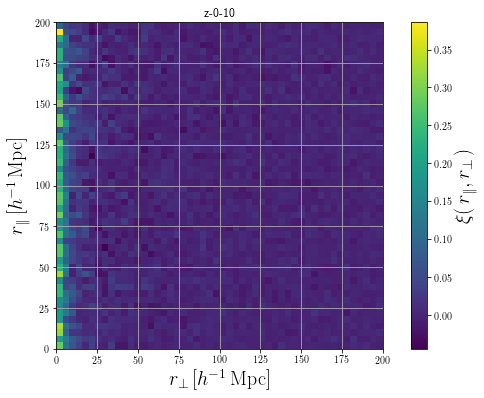

In [298]:
power = 0
for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    extent = [rt_min, rt_max, rp_min, rp_max]
    r = convert1DTo2D(r,np,nt)
    da = convert1DTo2D(da,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    da[er==0.] = float('nan')
    plt.imshow(da*r**power, origin='lower',extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(paths['TITLE'])
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$\xi(\, r_{\parallel},r_{\perp} \,)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

### __Wedge plots__

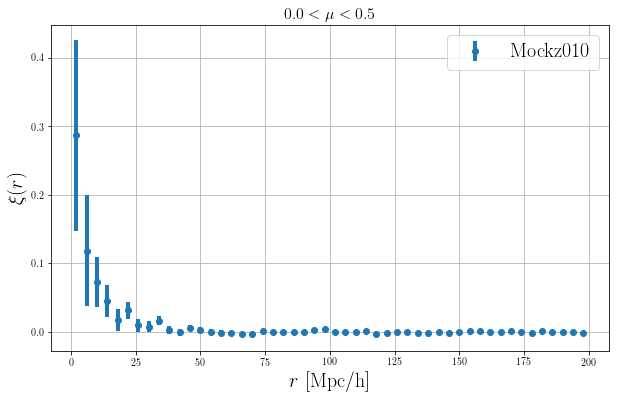

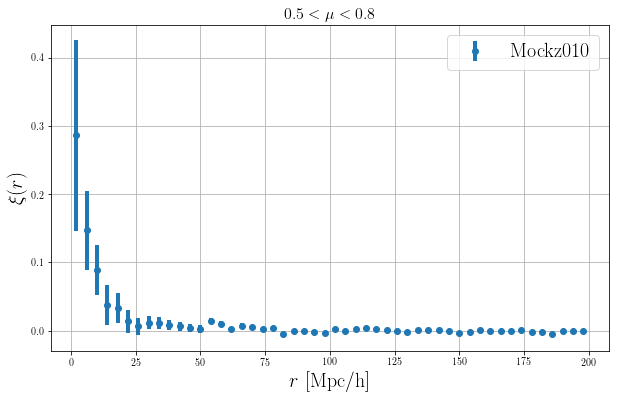

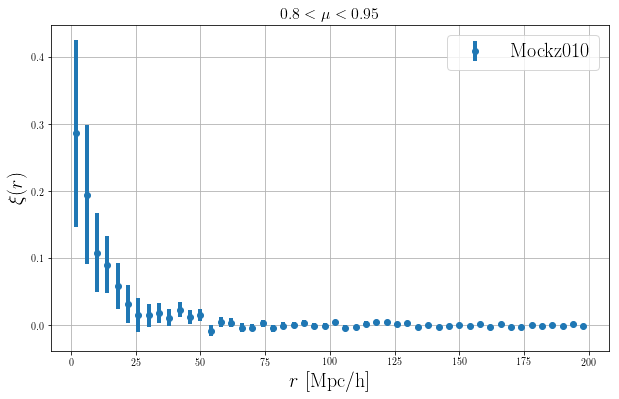

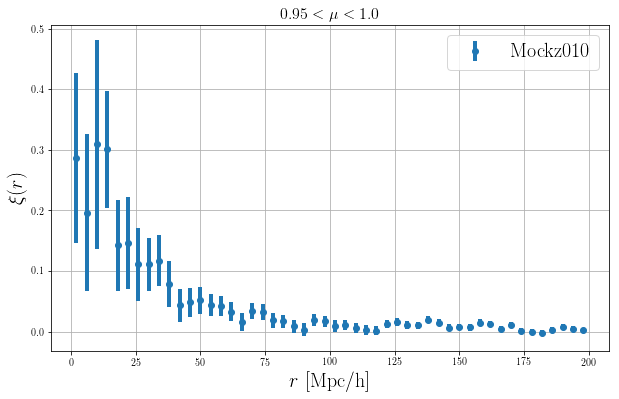

In [299]:
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        plt.errorbar(r,d,yerr=sp.sqrt(c.diagonal()),fmt="o",label=r'$\mathrm{'+name+'}$')
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

### __Slice plot__

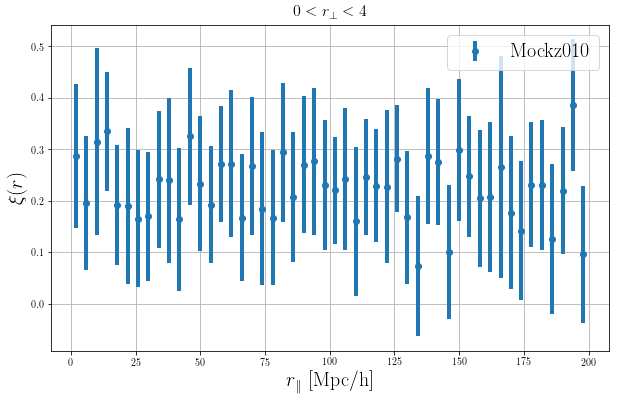

In [301]:
slices = [0]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

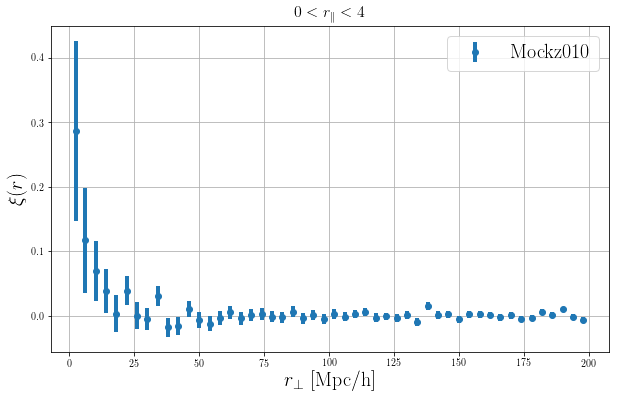

In [305]:
slices = [0]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drp = (h[1].read_header()['RPMAX']-h[1].read_header()['RPMIN']) / h[1].read_header()['NP']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        w = (rp>=s*drp) & (rp<(s+1)*drp)
        rt = rt[w]
        da = da[w]
        er = er[w]
        plt.errorbar(rt,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\perp}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\parallel<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()